# Comparison of All Models - Backtesting, Vizualization

This notebook compares all internal models, as well as the standard formula approach. The comparison will be done with the implemented backtesting in mind. 

Additional plots, and vizualizations might be presented.

# Lage innholdsfortegnelse

In [13]:
from internal_models.historical_simulation.historical_simulation import HistoricalSimulation
from internal_models.montecarlo.mc_copula import MonteCarloCopula
from internal_models.montecarlo.mc_vanillagbm import MonteCarloVanillaGBM
from internal_models.montecarlo.mc_jumpgbm import MonteCarloJumpGBM
from backtesting.christoffersens_test import christoffersen_independence_test
from backtesting.kupiec_test import kupiec_pof_test
from internal_models.GANs.tuned_GANS import solveig_GAN, astrid_GAN, willow_GAN
from utilities.bof_var_plot import plot_bof_var
from utilities.model_saving import save_results, is_results_empty, load_results
from utilities.bof_var_plot import plot_bof_var
from utilities.gan_plotting import extensive_plotting

import pandas as pd
from tqdm import tqdm
import numpy as np
from dotenv.main import load_dotenv
load_dotenv(override=True)
import os

### Fixing the data. Splitting the data in a testing period.

Split date is set inside environment file.

In [2]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)
    
    pre_test_df = df[df.index < start_test_date]
    test_df = df[df.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

### Deciding on weights for portfolio

**ATTENTION:** Assuming an equally weighted portfolio for now

In [3]:
num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

### Other Parameters

In [4]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
bof_0 = assets_0 - liabilities_0

## Calculating SCR with common Internal Models

I.e the following models:

- Historical Simulation
- Monte Carlo simulations with Copulas (Student t's)
- Monte Carlo, vanilla GBM. No correlations between assets assumed
- Monte Carlo, GBM with jumps and correlations between assets

In [5]:
hs = HistoricalSimulation(returns_df, weights)
mc_copula = MonteCarloCopula(returns_df, weights)
mc_vanilla_GBM = MonteCarloVanillaGBM(returns_df, weights)
mc_jump_gbm = MonteCarloJumpGBM(returns_df, weights)

## Decide on using saved model results, or recalculating

In [6]:
use_saved = True

In [7]:
if not use_saved or is_results_empty():
    dist_hs, scr_hs = hs.calculate_distribution_and_scr()
    save_results(model_name="Historical Simulation", distribution=dist_hs, scr=scr_hs, weights=weights, overwrite=True)

    dist_mc_copula, scr_mc_copula = mc_copula.calculate_distribution_and_scr()
    save_results(model_name="MC Copula", distribution=dist_mc_copula, scr=scr_mc_copula, weights=weights, overwrite=False)

    dist_mc_vanilla_gbm, scr_mc_vanilla_gbm = mc_vanilla_GBM.calculate_distribution_and_scr()
    save_results(model_name="MC Vanilla GBM", distribution=dist_mc_vanilla_gbm, scr=scr_mc_vanilla_gbm, weights=weights, overwrite=False)

    dist_mc_jump_gbm, scr_mc_jump_gbm = mc_jump_gbm.calculate_distribution_and_scr()
    save_results(model_name="GBM with Poisson Jumps and Intra-Asset Correlations", distribution=dist_mc_jump_gbm, scr=scr_mc_jump_gbm, weights=weights, overwrite=False)

## Plotting Distributions and displaying the SCR

Where the SCR is the Value-at-Risk at 99.5%. 

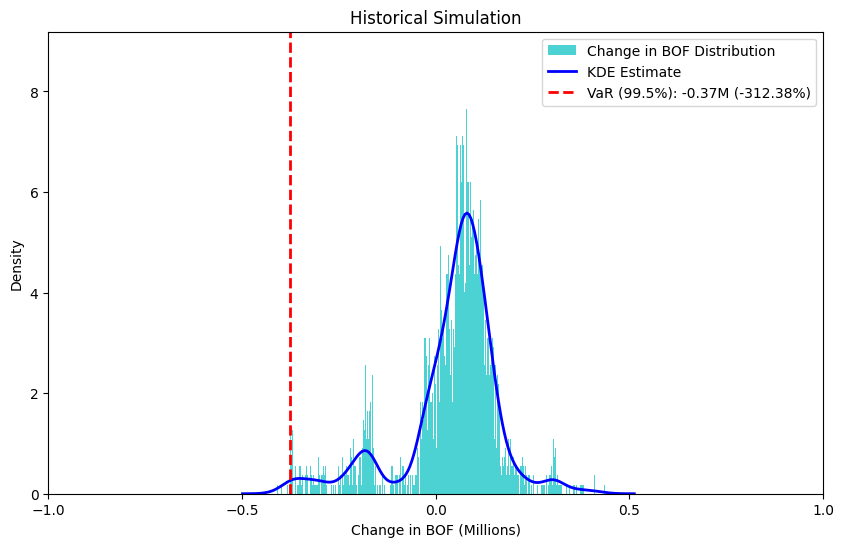

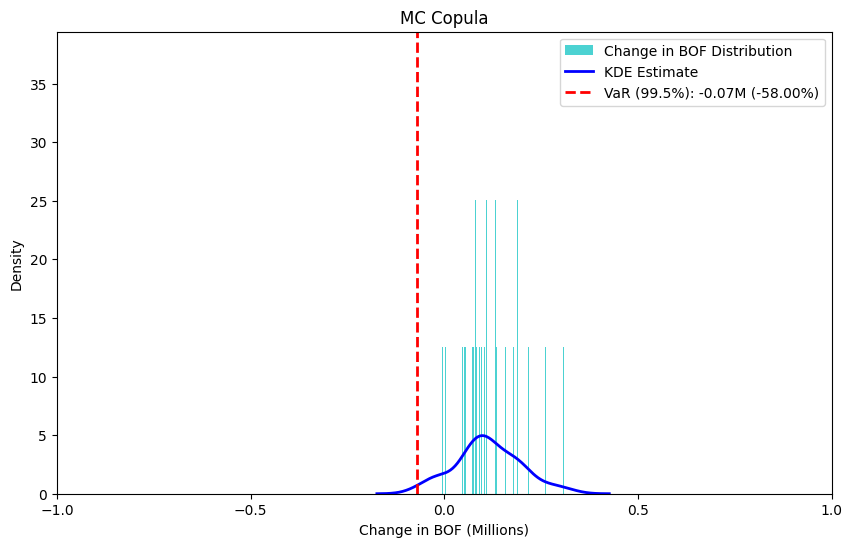

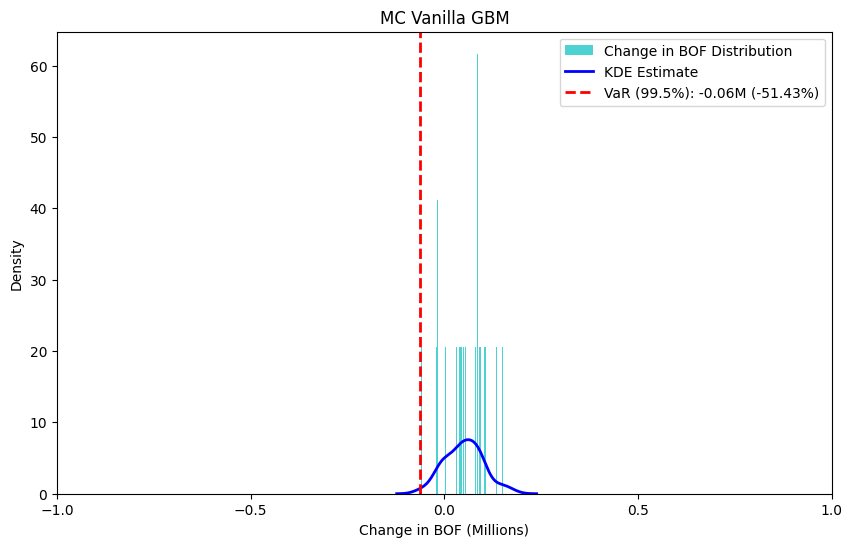

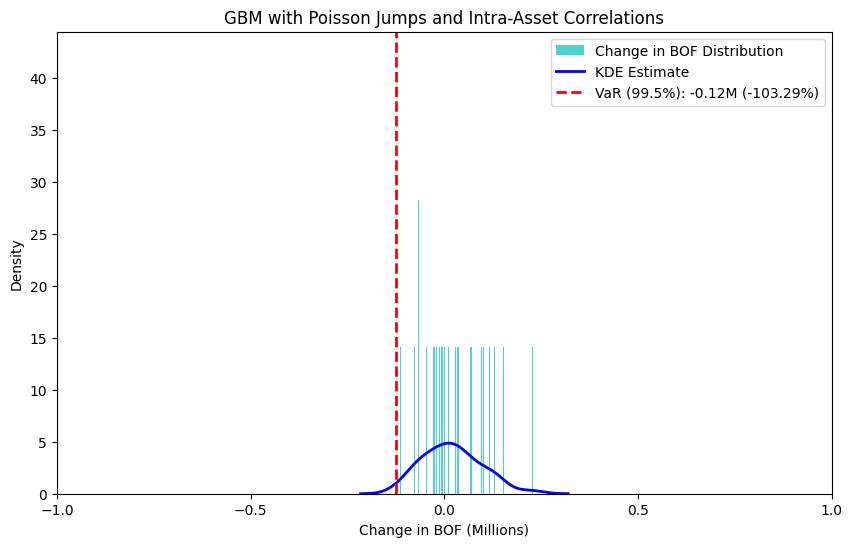

In [8]:
results = load_results()
for model_name, result in results.items():
    plot_bof_var(result['distribution'], result['scr'], model_name, bof_0),

## Internal Models using Neural Networks - GANs

Relevant plots:
- Generated distributions for each asset class, with statistics
- PCA plot
- Tests relevant to GANs
    - Mode Collaps
    - Variance
    - Wasserstein distance plot

A GAN is trained on each asset class, creating generated distribution for 1 year ahead. These distributions are then aggregated using Copulas.

In [9]:
from internal_models.GANs.tuned_GANS.astrid_GAN import AstridGAN
from internal_models.GANs.tuned_GANS.willow_GAN import WillowGAN

## Training the GANs if spesified, otherwise the already generated returns will be used

In [ ]:
train_gans = False

In [10]:
if train_gans:
    for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
        print(f"Training GAN for {asset_name}...")
        asset_returns = returns_df[asset_name]

        if asset_name == 'EONIA':
            gan = WillowGAN(asset_returns, asset_name)
        else:
            gan = AstridGAN(asset_returns, asset_name)
        
        gan.train()
        
        print(f"Finished training GAN for {asset_name}.\n")

        gan.generate_scenarios(num_scenarios=10000)

        print(f"Finished generating scenarios GAN {asset_name}.\n")

Training GANs:   0%|          | 0/7 [00:00<?, ?asset/s]

Training GAN for REEL...
[Epoch 0/2000] [Batch 0/16] [D loss: -0.07278025150299072] [G loss: 0.369907945394516]
[Epoch 0/2000] [Batch 10/16] [D loss: -0.0032782554626464844] [G loss: 0.44094371795654297]
[Epoch 1/2000] [Batch 0/16] [D loss: -0.006931513547897339] [G loss: 0.2804034352302551]
[Epoch 1/2000] [Batch 10/16] [D loss: -0.0020309239625930786] [G loss: 0.36506029963493347]
[Epoch 2/2000] [Batch 0/16] [D loss: 0.048756420612335205] [G loss: 0.25285109877586365]
[Epoch 2/2000] [Batch 10/16] [D loss: -0.06383481621742249] [G loss: 0.3230668604373932]
[Epoch 3/2000] [Batch 0/16] [D loss: -0.11969798803329468] [G loss: 0.19637927412986755]
[Epoch 3/2000] [Batch 10/16] [D loss: -0.18236981332302094] [G loss: 0.3152815103530884]
[Epoch 4/2000] [Batch 0/16] [D loss: -0.12849822640419006] [G loss: 0.2103387415409088]
[Epoch 4/2000] [Batch 10/16] [D loss: -0.16841253638267517] [G loss: 0.3508879840373993]
[Epoch 5/2000] [Batch 0/16] [D loss: 0.08913123607635498] [G loss: 0.3976753950119

Training GANs:  14%|█▍        | 1/7 [19:24<1:56:24, 1164.02s/asset]

Finished generating scenarios GAN REEL.

Training GAN for PE...
[Epoch 0/2000] [Batch 0/16] [D loss: -0.15899115800857544] [G loss: 0.05206484720110893]
[Epoch 0/2000] [Batch 10/16] [D loss: 0.03507514297962189] [G loss: 0.13231678307056427]
[Epoch 1/2000] [Batch 0/16] [D loss: 0.17738519608974457] [G loss: 0.18731017410755157]
[Epoch 1/2000] [Batch 10/16] [D loss: -0.026613324880599976] [G loss: 0.3265501856803894]
[Epoch 2/2000] [Batch 0/16] [D loss: -0.1075756847858429] [G loss: 0.24790874123573303]
[Epoch 2/2000] [Batch 10/16] [D loss: -0.11467626690864563] [G loss: 0.27015790343284607]
[Epoch 3/2000] [Batch 0/16] [D loss: -0.03889313340187073] [G loss: 0.2532573342323303]
[Epoch 3/2000] [Batch 10/16] [D loss: -0.13394008576869965] [G loss: 0.36279892921447754]
[Epoch 4/2000] [Batch 0/16] [D loss: 0.06046554446220398] [G loss: 0.3264874517917633]
[Epoch 4/2000] [Batch 10/16] [D loss: -0.21047343313694] [G loss: 0.41637328267097473]
[Epoch 5/2000] [Batch 0/16] [D loss: 0.06263911724

Training GANs:  29%|██▊       | 2/7 [38:58<1:37:31, 1170.29s/asset]

Finished generating scenarios GAN PE.

Training GAN for MSCIWORLD...
[Epoch 0/2000] [Batch 0/16] [D loss: 0.0950799286365509] [G loss: 0.3554948568344116]
[Epoch 0/2000] [Batch 10/16] [D loss: -0.1771957278251648] [G loss: 0.3590146601200104]
[Epoch 1/2000] [Batch 0/16] [D loss: -0.0033460259437561035] [G loss: 0.44164857268333435]
[Epoch 1/2000] [Batch 10/16] [D loss: -0.07075962424278259] [G loss: 0.23322975635528564]
[Epoch 2/2000] [Batch 0/16] [D loss: 0.08641514182090759] [G loss: 0.316884309053421]
[Epoch 2/2000] [Batch 10/16] [D loss: -0.02666527032852173] [G loss: 0.41843071579933167]
[Epoch 3/2000] [Batch 0/16] [D loss: -0.1426568627357483] [G loss: 0.5504003763198853]
[Epoch 3/2000] [Batch 10/16] [D loss: 0.06663209199905396] [G loss: 0.5298904180526733]
[Epoch 4/2000] [Batch 0/16] [D loss: -0.09095907211303711] [G loss: 0.4224402606487274]
[Epoch 4/2000] [Batch 10/16] [D loss: -0.014989644289016724] [G loss: 0.3682241141796112]
[Epoch 5/2000] [Batch 0/16] [D loss: -0.1002123

Training GANs:  43%|████▎     | 3/7 [58:29<1:18:02, 1170.62s/asset]

Finished generating scenarios GAN MSCIWORLD.

Training GAN for IG...
[Epoch 0/2000] [Batch 0/16] [D loss: -0.06431233882904053] [G loss: 0.24794529378414154]
[Epoch 0/2000] [Batch 10/16] [D loss: 0.10444550216197968] [G loss: 0.24111385643482208]
[Epoch 1/2000] [Batch 0/16] [D loss: -0.08226799964904785] [G loss: 0.1486317664384842]
[Epoch 1/2000] [Batch 10/16] [D loss: 0.04851219058036804] [G loss: 0.19602324068546295]
[Epoch 2/2000] [Batch 0/16] [D loss: 0.2929626405239105] [G loss: 0.056951671838760376]
[Epoch 2/2000] [Batch 10/16] [D loss: -0.009339004755020142] [G loss: 0.31478503346443176]
[Epoch 3/2000] [Batch 0/16] [D loss: 0.16347870230674744] [G loss: -0.029578890651464462]
[Epoch 3/2000] [Batch 10/16] [D loss: 0.06621813774108887] [G loss: 0.4055888056755066]
[Epoch 4/2000] [Batch 0/16] [D loss: -0.018782809376716614] [G loss: 0.04966804012656212]
[Epoch 4/2000] [Batch 10/16] [D loss: -0.03973689675331116] [G loss: 0.23848477005958557]
[Epoch 5/2000] [Batch 0/16] [D loss: 0.

Training GANs:  57%|█████▋    | 4/7 [1:18:24<59:00, 1180.04s/asset]

Finished generating scenarios GAN IG.

Training GAN for GOV...
[Epoch 0/2000] [Batch 0/16] [D loss: 0.22080206871032715] [G loss: 0.12963268160820007]
[Epoch 0/2000] [Batch 10/16] [D loss: -0.05470450222492218] [G loss: 0.22239921987056732]
[Epoch 1/2000] [Batch 0/16] [D loss: -0.08075970411300659] [G loss: 0.1347190886735916]
[Epoch 1/2000] [Batch 10/16] [D loss: -0.1679108589887619] [G loss: 0.20440734922885895]
[Epoch 2/2000] [Batch 0/16] [D loss: -0.011824369430541992] [G loss: 0.2605213522911072]
[Epoch 2/2000] [Batch 10/16] [D loss: 0.1841825246810913] [G loss: 0.2364206314086914]
[Epoch 3/2000] [Batch 0/16] [D loss: -0.125596284866333] [G loss: 0.3017958104610443]
[Epoch 3/2000] [Batch 10/16] [D loss: 0.17599272727966309] [G loss: 0.33950039744377136]
[Epoch 4/2000] [Batch 0/16] [D loss: 0.06470602750778198] [G loss: 0.28570079803466797]
[Epoch 4/2000] [Batch 10/16] [D loss: 0.12793108820915222] [G loss: 0.2857060134410858]
[Epoch 5/2000] [Batch 0/16] [D loss: -0.193801656365394

Training GANs:  71%|███████▏  | 5/7 [1:37:57<39:15, 1177.70s/asset]

Finished generating scenarios GAN GOV.

Training GAN for HY...
[Epoch 0/2000] [Batch 0/16] [D loss: -0.08380831778049469] [G loss: -0.1131523922085762]
[Epoch 0/2000] [Batch 10/16] [D loss: -0.1485363245010376] [G loss: -0.16223402321338654]
[Epoch 1/2000] [Batch 0/16] [D loss: 0.23053450882434845] [G loss: -0.06090940162539482]
[Epoch 1/2000] [Batch 10/16] [D loss: -0.061617329716682434] [G loss: 0.03151826933026314]
[Epoch 2/2000] [Batch 0/16] [D loss: 0.04659801721572876] [G loss: -0.02395898848772049]
[Epoch 2/2000] [Batch 10/16] [D loss: 0.3285370171070099] [G loss: 0.059787336736917496]
[Epoch 3/2000] [Batch 0/16] [D loss: -0.15866397321224213] [G loss: -0.14000239968299866]
[Epoch 3/2000] [Batch 10/16] [D loss: -0.02293940633535385] [G loss: 0.00891211535781622]
[Epoch 4/2000] [Batch 0/16] [D loss: -0.017590466886758804] [G loss: 0.07401315867900848]
[Epoch 4/2000] [Batch 10/16] [D loss: 0.01815498247742653] [G loss: 0.06697439402341843]
[Epoch 5/2000] [Batch 0/16] [D loss: 0.09

Training GANs:  86%|████████▌ | 6/7 [1:57:55<19:44, 1184.57s/asset]

Finished generating scenarios GAN HY.

Training GAN for EONIA...


c:\Users\nicka\master-thesis\internal_models\GANs\tuned_GANS\willow_GAN.py:89: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recency_loss = F.mse_loss(gen_returns.mean(dim=1), real_returns.mean(dim=1))  # Match recent mean trend


[Epoch 0/2000] [Batch 0/25] [D loss: 0.016338009387254715] [G loss: 0.2022978663444519] [Recency Loss: 1.2565491199493408]
[Epoch 0/2000] [Batch 10/25] [D loss: 0.017449095845222473] [G loss: -0.015675013884902] [Recency Loss: 1.2556636333465576]
[Epoch 0/2000] [Batch 20/25] [D loss: -0.2785934805870056] [G loss: 0.16953128576278687] [Recency Loss: 1.2550675868988037]


c:\Users\nicka\master-thesis\internal_models\GANs\tuned_GANS\willow_GAN.py:89: UserWarning: Using a target size (torch.Size([115, 1])) that is different to the input size (torch.Size([115])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recency_loss = F.mse_loss(gen_returns.mean(dim=1), real_returns.mean(dim=1))  # Match recent mean trend


[Epoch 1/2000] [Batch 0/25] [D loss: -0.15355834364891052] [G loss: 0.2539617419242859] [Recency Loss: 1.2535368204116821]
[Epoch 1/2000] [Batch 10/25] [D loss: 0.008814379572868347] [G loss: 0.1072688102722168] [Recency Loss: 1.251600742340088]
[Epoch 1/2000] [Batch 20/25] [D loss: 0.08630429953336716] [G loss: 0.12118104845285416] [Recency Loss: 1.2499827146530151]
[Epoch 2/2000] [Batch 0/25] [D loss: -0.13209348917007446] [G loss: 0.2171926498413086] [Recency Loss: 1.2494949102401733]
[Epoch 2/2000] [Batch 10/25] [D loss: -0.131976917386055] [G loss: 0.20511244237422943] [Recency Loss: 1.248044490814209]
[Epoch 2/2000] [Batch 20/25] [D loss: 0.05140720307826996] [G loss: 0.3822731375694275] [Recency Loss: 1.2450439929962158]
[Epoch 3/2000] [Batch 0/25] [D loss: -0.13092413544654846] [G loss: 0.11706279963254929] [Recency Loss: 1.2447904348373413]
[Epoch 3/2000] [Batch 10/25] [D loss: -0.13219937682151794] [G loss: 0.23905980587005615] [Recency Loss: 1.2427546977996826]
[Epoch 3/2000

Training GANs: 100%|██████████| 7/7 [2:28:39<00:00, 1274.18s/asset]

Finished generating scenarios GAN EONIA.



Presenting GAN results


Statistical Summary for REEL - Real Data:
Mean: 193.261827
Std Dev: 12915.831965
Skewness: -0.270455
Kurtosis: 4.969021
99.5% VaR: -51644.473240

Statistical Summary for REEL - Generated Data:
Mean: -6.819199
Std Dev: 24641.312500
Skewness: 0.318428
Kurtosis: 16.334999
99.5% VaR: -98734.039062


ValueError: `bins` must be positive, when an integer

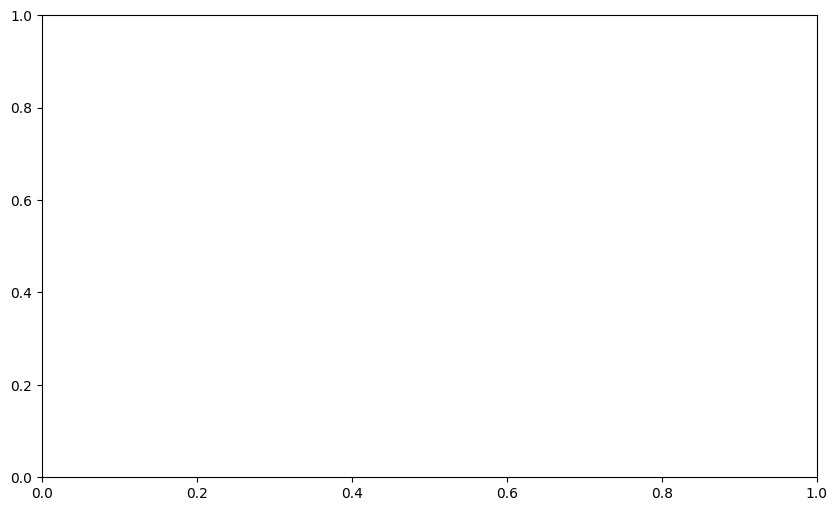

In [12]:
extensive_plotting(scaled=False, returns_df=returns_df)

## Add a Preliminary backtesting for each individual GAN

## Aggregating the GAN distributions together - Copulas

When aggregated we display the BOF distribtion, as well as the SCR.

In [ ]:
# Collecting them toghether

## Adding Standard Formula

## Performing Backtesting

On 1-year out of sample data, the start of the testing period is defined as START_TEST_DATE inside .env.

Need proper visualization here..

Adaquecy tests:
- Kupiec
- Christoffersens

Accuracy tests:


In [ ]:
def get_failures_testing(scr):
    bof_0 = assets_0 - liabilities_0

    failures = []

    for t in range(len(test_returns_df)):
        portfolio_return = (test_returns_df.iloc[t].values * weights).sum()
        assets_t1 = assets_0 * (1 + portfolio_return)

        eonia_return = test_returns_df.iloc[t, 6]  
        liabilities_t1 = liabilities_0 * (1 + eonia_return)

        bof_t1 = assets_t1 - liabilities_t1

        delta_bof = bof_t1 - bof_0

        failure = 1 if delta_bof < scr else 0
        failures.append(failure)

    return np.array(failures)

In [ ]:
failures_hs = get_failures_testing(scr_hs)
failures_mc_copula = get_failures_testing(scr_mc_copula)

test_stat_ctest_hs, p_value_ctest_hs = christoffersen_independence_test(failures_hs)
test_stat_ctest_mc_copula, p_value_ctest_mc_copula = christoffersen_independence_test(failures_mc_copula)

test_stat_ktest_hs, p_value_ktest_hs = kupiec_pof_test(failures_hs)
test_stat_ktest_mc_copula, p_value_ktest_mc_copula = kupiec_pof_test(failures_mc_copula)

In [ ]:
alpha = 0.05

test_results = {
    'Model': ['Historical Simulation', 'Monte Carlo Copula', 'Historical Simulation', 'Monte Carlo Copula'],
    'Test': ['Christoffersen', 'Christoffersen', 'Kupiec', 'Kupiec'],
    'Test Statistic': [test_stat_ctest_hs, test_stat_ctest_mc_copula, test_stat_ktest_hs, test_stat_ktest_mc_copula],
    'P-Value': [p_value_ctest_hs, p_value_ctest_mc_copula, p_value_ktest_hs, p_value_ktest_mc_copula]
}

results_df = pd.DataFrame(test_results)

# Add a column for Test Result based on p-value
results_df['Test Result'] = results_df['P-Value'].apply(lambda p: 'Pass' if p > alpha else 'Fail')

results_df

,Model,Test,Test Statistic,P-Value,Test Result
0,Historical Simulation,Christoffersen,-0.000000,1.000000,Pass
1,Monte Carlo Copula,Christoffersen,-0.000000,1.000000,Pass
2,Historical Simulation,Kupiec,2.526321,0.111961,Pass
3,Monte Carlo Copula,Kupiec,2.526321,0.111961,Pass


In [ ]:
failures_hs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
failures_mc_copula

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])